## 逻辑斯特回归示例

- [逻辑斯特回归](#逻辑斯特回归)
- [正则化后的逻辑斯特回归](#加正则化项的逻辑斯特回归)

In [145]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('dark')

In [146]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

In [147]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # 获得正负样本的下标(即哪些是正样本，哪些是负样本)
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

In [148]:
data =  loaddata('../../Demo_Ref/Linear-models/logistic_regression/data1.txt', ',')

Dimensions:  (100, 3)
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


In [152]:
X = np.c_[np.ones((data.shape[0],1)),data[:,0:2]]#将ndarray转为多维数组
y = np.c_[data[:,2]]


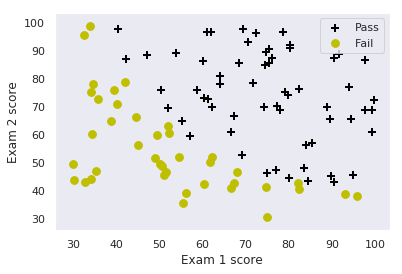

In [153]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Pass', 'Fail')

#### 逻辑斯特回归假设
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [154]:
#定义sigmoid函数
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

其实scipy包里有一个函数可以完成一样的功能:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

#### 损失函数(交叉伤损失函数)
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### 向量化的损失函数(矩阵形式)
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

In [155]:
#定义损失函数
def costFunction(theta, X, y):
    m = y.size
    
    h = sigmoid(X.dot(theta))
    
    J = -1.0*(1.0/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))
               
    if np.isnan(J[0]):
        return(np.inf)
    return J[0]

In [157]:
#### 求偏导(梯度)

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
#### 向量化的偏导(梯度)
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$


In [158]:
#求解梯度
def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    
    grad =(1.0/m)*X.T.dot(h-y)

    return(grad.flatten())

In [247]:
# 梯度下降
def gradientDescent(X, y, theta=[[0],[0],[0]], theta_size = 3,alpha=0.01, num_iters=38000):
    m = y.size
    trans_theta=np.zeros(theta_size)
    J_history = np.zeros(num_iters)
    for iter in np.arange(num_iters):
        
        
        for i in np.arange(theta_size):
            trans_theta[i] = theta[i][0]
        h = sigmoid(X.dot(trans_theta.reshape(-1,1)))
        theta = theta - alpha*(1.0/m)*(X.T.dot(h-y))
        
       # print(theta)
        J_history[iter] = costFunction(theta,X, y)
    return(theta, J_history)

In [248]:
initial_theta = np.zeros(X.shape[1])
print(initial_theta)
print(type(initial_theta))
cost = costFunction(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print('Cost: \n', cost)
print('Grad: \n', grad)

[0. 0. 0.]
<class 'numpy.ndarray'>
Cost: 
 0.6931471805599453
Grad: 
 [ -0.1        -12.00921659 -11.26284221]


In [245]:
#根据自定义的梯度下降函数求解参数值
theta, J_history = gradientDescent(X, y)
print(theta)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


[[-41.82989202]
 [  0.48528585]
 [  0.46352515]]


In [246]:
#根据scikit-learn中的minmize函数求解参数值
res = minimize(costFunction, initial_theta, args=(X,y), jac=gradient, options={'maxiter':400})

accuracy = 100.0*sum(predict(res.x, X) == y.ravel())/y.size 
print(type(res.x))
temp_theta = np.zeros(theta.shape[0])

for i in np.arange(theta.shape[0]):
    temp_theta[i] = theta[i][0]
accuracy1 = 100.0*sum(predict(temp_theta, X) == y.ravel())/y.size    
print(accuracy1)
print(accuracy)
print(res)

<class 'numpy.ndarray'>
65.0
89.0
      fun: 0.2034977015895099
 hess_inv: array([[ 2.85339493e+03, -2.32908823e+01, -2.27416470e+01],
       [-2.32908823e+01,  2.04489131e-01,  1.72969525e-01],
       [-2.27416470e+01,  1.72969525e-01,  1.96170322e-01]])
      jac: array([-2.68557620e-09,  4.36433485e-07, -1.39671757e-06])
  message: 'Optimization terminated successfully.'
     nfev: 34
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([-25.16131634,   0.2062316 ,   0.20147143])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [182]:

#根据scikit-learn中的minmize函数求解参数值进行预测
def predict(theta,X,threshold=0.5):
    p = sigmoid(X.dot(theta.T))>=threshold
    return (p.astype('int'))


#根据自定义的梯度下降求出的参数值进行预测
def yspredict(theta,X,threshold=0.5):
    print(theat.shape)
    print(X.shape)
    p = sigmoid(X.dot(theta))>=threshold
    return (p.astype('int'))

In [164]:
result = yspredict(theta,np.array([1,20, 85]),threshold=0.5)
print(result)


[1]


AttributeError: 'numpy.ndarray' object has no attribute 'x'

IndexError: index 2 is out of bounds for axis 1 with size 2

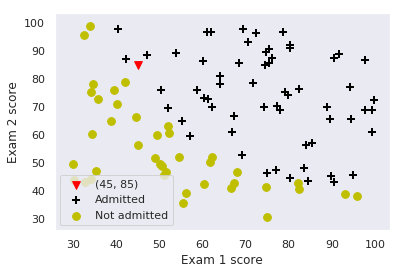

In [129]:
#绘制决策边界
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
#contour绘制直线
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

In [ ]:
### 加正则化项的逻辑斯特回归

data1 =  loaddata('../../Demo_Ref/Linear-models/logistic_regression/data2.txt', ',')
X = data1[:,0:2]
y = np.c_[data1[:,2]]

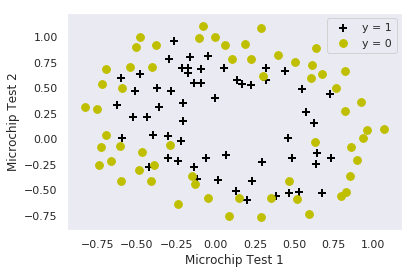

In [130]:
# 画个图
plotData(data1, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

#### 整一点多项式特征出来(最高6阶)

In [131]:
poly = PolynomialFeatures(6)
XX = poly.fit_transform(data1[:,0:2])
# 看看形状(特征映射后x有多少维了)
XX.shape

(118, 28)

#### 正则化后损失函数
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### 向量化的损失函数(矩阵形式)
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [132]:
# 定义损失函数
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
   
    J = -1.0*(1.0/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2.0*m))*np.sum(np.square(theta[1:]))

    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

#### 偏导(梯度)

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### 向量化的偏导(梯度)
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{注意，我们另外自己加的参数 } \theta_{0} \text{ 不需要被正则化}$$

In [133]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1.0/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [141]:
# 自定义梯度下降
def gradientDescent_zz(X, y, theta, theta_size,reg,alpha=0.01, num_iters=400):
    print("111")
    m = y.size
    trans_theta=np.zeros(theta_size)
    J_history = np.zeros(num_iters)
    
    for iter in np.arange(num_iters):
        #for i in np.arange(theta_size):
         #   trans_theta[i] = theta[i][0]
        #h = sigmoid(X.dot(trans_theta.reshape(-1,1)))
        h = sigmoid(X.dot(theta.reshape(-1,1)))
        theta = (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
     
        c = X.T.dot(h-y)+theta
       
        y = y.reshape(-1,1)

        b = alpha*((1.0/m)*(X.T.dot(h-y))+theta)
        
        theta = theta - b
        
       # print(theta)
        J_history[iter] = costFunction(theta,X, y)
    return(theta, J_history)

In [142]:
initial_theta = np.zeros(XX.shape[1])
print(XX.shape)
print(type(initial_theta))
print(initial_theta.shape[0])
theta,J_history = gradientDescent_zz(XX, y,initial_theta,initial_theta.shape[0],0.1)

(118, 28)
<class 'numpy.ndarray'>
28
111


In [143]:
print(res2.x.shape)
print(theta.shape)
print(type(res2.x.shape))
print(type(theta.shape)) 

(28,)
(28, 1)
<class 'tuple'>
<class 'tuple'>


111
log
0.0
(28, 1)
(118, 28)
accuracy is 
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]


/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


111
log
1.0
(28, 1)
(118, 28)
accuracy is 
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]
111
log
100.0
(28, 1)
(118, 28)
accuracy is 
[ 1.69491525  1.69491525  1.69491525  1.69491525  1.69491525  1.69491525
  1.69491525  1.69491525  1.69491525  1.69491525  1.69491525  1.69491525
  1.69491525  1.69491525  1.69491525  1.69491525  1.69491525  1.69491525
  1.69491525  1.69491525  1.69491525  1.69491525  1.69491525  1.69491525
  1.69491525  1.6949

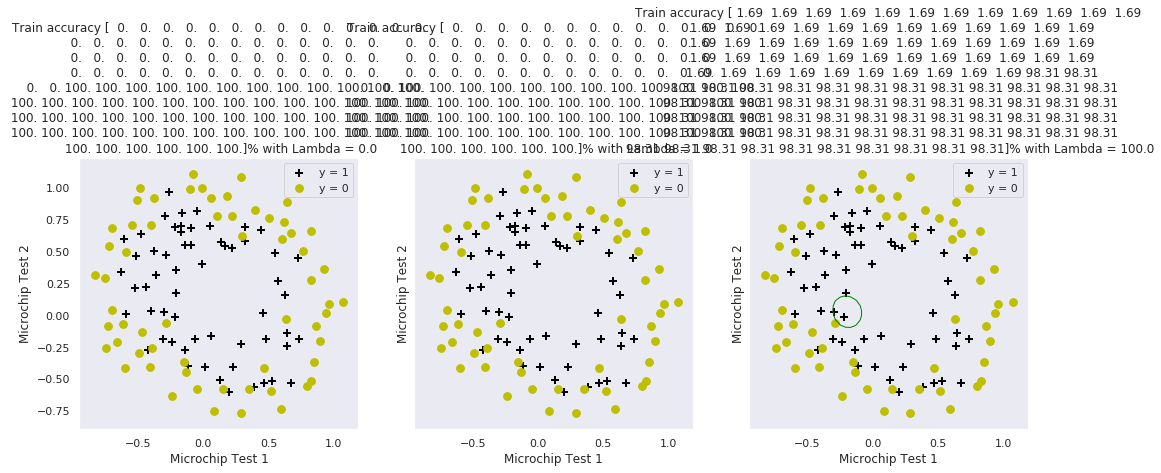

In [144]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# 决策边界，咱们分别来看看正则化系数lambda太大太小分别会出现什么情况
# Lambda = 0 : 就是没有正则化，这样的话，就过拟合咯
# Lambda = 1 : 这才是正确的打开方式
# Lambda = 100 : 卧槽，正则化项太激进，导致基本就没拟合出决策边界

for i, C in enumerate([0.0, 1.0, 100.0]):
    # 最优化 costFunctionReg
    #res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), jac=gradientReg, options={'maxiter':3000})
    theta,J_history = gradientDescent_zz(XX, y,initial_theta,initial_theta.shape[0],C)
    # 准确率
    #accuracy = 100.0*sum(predict(res2.x, XX) == y.ravel())/y.size 
    print("log")
    print(C)
    print(theta.shape)
    print(XX.shape)
    accuracy = 100.0*sum(yspredict(theta, XX) == y.ravel())/y.size
    print("accuracy is ")
    print(accuracy)
    # 对X,y的散列绘图
    plotData(data1, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # 画出决策边界
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    #h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(theta))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))